In [ ]:
import array as arr
from BTrees.IIBTree import IIBTree # documentation, https://pythonhosted.org/BTrees/ 
import csv
# import queue    # see https://docs.python.org/3/library/queue.html#module-queue
import math
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
# from matplotlib.collections import Poly3DCollection # https://stackoverflow.com/questions/10599942/drawing-a-rectangle-or-bar-between-two-points-in-a-3d-scatter-plot-in-python-and
# and https://stackoverflow.com/questions/37585340/plotting-3d-polygons-in-python-3
import numpy as np
from trajectory import * # import the trapezoidal trajectory
import time

# interesting/useful websites
# talks about implementing robot simulator: https://www.toptal.com/robotics/programming-a-robot-an-introductory-tutorial  
#    said robot simulator code: https://github.com/nmccrea/sobot-rimulator/blob/v1.0.0/models/supervisor.py

In [ ]:
def step(t, dt):
    t = t + dt
    return t

In [ ]:
class drawRobot(object):
    def __init__(self):
        self.a = 0
        
    def drawRect(self, q_curr, width_v, length_v):

        xl  = q_curr[0] + width_v / 2  # left x coordinate
        xr  = q_curr[0] - width_v / 2  # right x coordinate

        yf  = q_curr[1] - length_v / 2 # front
        yb  = q_curr[1] + length_v / 2 # back

        verts = []

        xs = [xr, xl, xl, xr, xr]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        ys = [yf, yf, yb, yb, yf]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        z_axis = [0, 0, 0, 0, 0]

        verts = [list(zip(xs, ys, z_axis))]

        poly = Poly3DCollection(verts, facecolors="blue", closed = False)
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
        
    def drawFrame(self, left_edge, back_edge, front_edge, z_edges_f):
        xl  = left_edge  # back x coordinate
        
        yf  = front_edge # front y coordinate
        yb  = back_edge  # back y coordinate

        zt  = z_edges_f[0]  # top z coordinate
        zb  = z_edges_f[1]  # bottom z coordinate

        verts = []
        
        xs = [xl, xl, xl, xl, xl]
        ys = [yf, yb, yb, yf, yf]  # each box has 4 vertices, give it 5 to close it, these are the x coordinates
        z_axis = [zt, zt, zb, zb, zt]  # each box has 4 vertices, give it 5 to close it, these are the y coordinates
        
        verts = [list(zip(xs, ys, z_axis))]
        
        poly = Poly3DCollection(verts, closed = False, alpha=0.25)
        poly.set_facecolor("grey")  # the transparency setting (alpha) is overriden by facecolor otherwise
        ax.add_collection3d(poly, zs=[z_axis[0]] * len(verts), zdir='z')
        
    def drawArmCylinder(self, center_y, center_z, arm_start, arm_end):
        # see second answer https://stackoverflow.com/questions/26989131/add-cylinder-to-plot
        radius = 0.2 # set arbitrarily 
        
        x     = np.linspace(arm_start, arm_end, 3)
        theta = np.linspace(0, 2*np.pi, 3)
        
        theta_grid, x_grid = np.meshgrid(theta, x)
        
        y_grid = radius*np.cos(theta_grid) + center_y
        z_grid = radius*np.sin(theta_grid) + center_z
        
        return x_grid,y_grid,z_grid
            
#                     Xc,Yc,Zc = data_for_cylinder_along_z(0.2,0.2,0.05,0.1)
#                     ax.plot_surface(Xc, Yc, Zc, alpha=0.5)

In [ ]:
def vehicleStep(q_curr, v, dt):
    # for now it's constant velocity  
    q_new = np.array([q_curr[0] + v[0]*dt, q_curr[1] + v[1]*dt])
    return q_new

In [ ]:
class camera(object):
    def __init__(self, length_v, n_row, frame_height):      
        
        #################### CLASS VARIABLES ####################
        self.width = length_v  # width of camera view, in m
        self.i_lastFruit = 0   # last visited fruit index
        
        # lists of coordinates of picked fruits
        self.x      = []
        self.y      = []
        self.z      = []
        self.t_pick = []        # time when fruit was picked
        
        # list of fruits passed by the vehicle
        self.passed_fruit = []
        
        # Settings for the row
        self.row_n  = n_row     # row number, in one sided-version, lower number means lower on the vehicle
        self.height = frame_height # how high of fruit can this row see

        self.mid_location = (  # tuple used to determine the location of the middle of the row
            self.height/2,
            self.height + self.height/2,
            2*self.height + self.height/2
        )
        
        self.row_mid = self.mid_location[self.row_n] # find the row height for this arm => might not need self

        # calculate the up-down edges of the camera once
        self.view_bot = self.row_mid - self.height / 2 # up-down edges
        self.view_top = self.row_mid + self.height / 2
        
#         print("top:", self.view_top, "bottom:", self.view_bot)
        
        # side edges of the camera
        self.view_min = 0.
        self.view_max = 0.
        
        
        ######################## MODULES ########################
        self.fruitBTree    = IIBTree()
        
               
        
    ######################## FUNCTIONS ########################
    def cameraStep(self, end_row, q_curr, sortedFruit):
        # centered (for now) on the vehicle, perpendicular to data's y-axis
        self.view_min = q_curr - self.width / 2 # side edges
        self.view_max = q_curr + self.width / 2
        
        # fix side end constraints of beginning and end 
        if self.view_min < 0:
            self.view_min = 0 # will need to change this to a beginning value like below

#         if self.view_max > end_row:
#             self.view_max = end_row + self.width / 2
            
        j = self.i_lastFruit # the last fruit that was added (so it repeats less)
            
        # do the same but updating a b-tree instead for better searchability
        while(True):
            if sortedFruit[1,j] > self.view_min and sortedFruit[1,j] < self.view_max:
                # now check vertical edges
                if sortedFruit[2,j] > self.view_bot and sortedFruit[2,j] < self.view_top:
                    # now check if it has been picked before
                    if sortedFruit[3,j] == 0:
                        # convert the y-location into an integer so it can be used as a key, ceiling because it's at the edge
                        # so it can't really be used either way as a goal
                        key = math.ceil(sortedFruit[1,j]*1000) 
                        # add the value to the b-tree
                        self.fruitBTree.update({key:j})
                
            elif sortedFruit[1,j] > self.view_max:
                # no fruit left to add
                break
            j = j + 1
            
        ## delete fruit that's behind the vehicle => put in a seperate set
        # can use it to figure out what speed the vehicle should go => number of fruits left behind?
        if len(self.fruitBTree) > 0:
            self.passedFruit()
            
        self.i_lastFruit = j
        
    
    def passedFruit(self):  
        # removal of all smaller keys than the vehicle's edge from B-Tree
        edge_key  = math.ceil(self.view_min*1000) # edge being passed
        
        try: # if no key exists after the potential key, break out rather than crash the program
            max_key_pop = self.fruitBTree.maxKey(edge_key)
            
            for k in self.fruitBTree.keys():
                if k < max_key_pop:
                    # so it doesn'thave to go through the whole B-Tree
                    self.passed_fruit.append(self.fruitBTree.pop(k))
                else:
                    break         

        except ValueError:
#             print("*** No key smaller than the edge value, broke out of the if statement ***")
            return
            
    
    
    def fruitPicked(self, pointCoord, t):
        self.x.append(float(pointCoord[0]))
        self.y.append(float(pointCoord[1]))
        self.z.append(float(pointCoord[2]))
        self.t_pick.append(float(t))
        
        
    def packFruit(self):
        x_fr = np.array(self.x)
        y_fr = np.array(self.y)
        z_fr = np.array(self.z)
        t    = np.array(self.t_pick)

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        inv_fruit = np.stack([x_fr, y_fr, z_fr, t])
        
        return inv_fruit
        


In [ ]:
# def schedule(indexVisFruit):
    # start simple by just popping out the next value (see if we can do this)
#     i_goal = indexVisFruit.get()
#     print(i_goal)

In [374]:
class arm(object):
    def __init__(self, q, n, frame_width, frame_height, row_n, max_vel, max_accel):
        
        ## next level would be for them to be seperate threads with access to the global clock
              
        #################### CLASS VARIABLES ####################
        self.n             = n                           # arm number 
        self.row_n         = row_n                       # which row this arm is located in
        self.q_a           = np.array([q[0],q[1],q[2]])  # arm's location in the world's frame of reference
        self.v_a           = np.array([0.,0.,0.])        # arm's current velocity in the three axis
        
        # list of all locations where arm was
        self.qax           = []
        self.qay           = []
        self.qaz           = []
        
        self.length_f      = 2.5          # how far can it go into trees, in m
        self.width_f       = frame_width  # size of enclosing frame, width in m
        self.height_f      = frame_height # size of enclosing frame, height in m
        
        # frame center coordinates
        self.q_f           = np.array([q[0],q[1],q[2]])  # frame's location in the world's frame of reference
        # edges of the frame
        self.x_edges_f     = np.array([0.,0.]) # 0 is the starting position, 1 is max extension
        self.y_edges_f     = np.array([0.,0.]) # 0 is forward, 1 is in the back
        self.z_edges_f     = np.array([0.,0.]) # 0 is the top, 1 is the bottom
        
        # values for trapezoid trajectory (parameters to play with...)
        self.v_max         = max_vel 
        self.a_max         = max_accel  
        self.d_max         = max_accel 
        
        # can the arm be given a goal, or does it already have one
        self.free          = 1     # start ready to be given a goal 
        self.goal          = np.array([0.,0.,0.])
        self.goal_r        = np.array([0,0,0]) # has the goal been rached at each axis
        self.reached_goals = 0     # how many goals were successfully reached 
        self.goal_index    = 0     # what index did the goal come from 
        
        # Flags
        self.x_move        = 0     # allows the x-dir to start moving
        self.retractFlag   = 0     # checks if the arm is retracting
        self.unloadFlag    = 0     # checks if the arm's moving to the conveyor
        
        # following the trapezoidal trajectory
        self.t             = 0.      # time at which the arm will begin moving to the goal
        self.tx            = 0.      # time at which the arm will begin moving in the x-dir
        self.tz            = 0.      # time used for unloading the fruit on conveyor (only z-dir)        
        # calculate the error between the final location and given goal coordinates 
        self.error         = np.array([0.,0.,0.])
        
        ######################## MODULES ########################
        self.x = Trajectory(self.v_max, self.a_max, self.d_max)
        self.y = Trajectory(self.v_max, self.a_max, self.d_max)
        self.z = Trajectory(self.v_max, self.a_max, self.d_max)
        
        ################ SELF FUNCTIONS AT INIT #################
        self.initFrame()
        
        
    ######################## FUNCTIONS ########################
    def armStep(self, v_v, dt, t):
        # AAAALLLLL THE AAARMMMSSSSSSSSS
        # v_v is the vehicle's velocity
        # q_curr is the arm's current location within the world frame 
        q_curr      = np.array([self.q_a[0],self.q_a[1],self.q_a[2]])
        
        epsilon     = 0.001           # allowable error when reaching fruit

        goal_time   = t - self.t      # time since the y-z self timer was started
        goal_time_x = t - self.tx     # time since the x self timer was started => not updating correctly
        
        if self.unloadFlag == 2: # if the arm is unloading
            goal_time_z = t - self.t_unload
        else:
            goal_time_z = goal_time 
    
        # move along with the vehicle
        self.moveFrame(v_v, dt)       # start with the frame
        
        # check if fruit can still be reached according to frame's location 
        can_reach   = self.reachable()
        
        if can_reach == 1:
            # at the moment trying to cancel the vehicle's velocity/movement's effect on the arms by subtracting it
            # in the y-axis:
            self.calcYVel(goal_time, v_v)
            # in the z-axis:  
            self.calcZVel(goal_time_z)  # not affected by the vehicle's velocity

            # if both y and z goal locations reached, start moving in the x-dir to grab the fruit
            if self.goal_r[1] == 1 and self.goal_r[2] == 1:
                # check that it's the first time this has been reached since a new goal was given
                if self.tx == 0.:        
                    self.tx     = t   # start time for the new timer for x
                    goal_time_x = 0.  # restart the timer for x
                    self.x_move = 1   # allow movement in the x-direction

            if self.x_move == 1: 
                self.calcXVel(goal_time_x, v_v)
              
        elif can_reach == 0:
            # set these at zero and check if arm has to be retracted or fruit unloaded
            # akes sure that these actions can still happen even if the arm's frame has moved beyond the fruit
            self.v_a[1] = 0
            self.v_a[2] = 0
            if self.retractFlag == 1: 
#                 print("THE ARRRMMMMMMSSSSS")
#                 print("THEY RETRACT?", self.retractFlag)
#                 print("GOOOOAL", goal_time_x)
                self.calcXVel(goal_time_x, v_v)
    
                if self.goal[0] != 1 or self.goal[1] != 1 or self.goal[2] != 1:
                    # if it's retracting before it reached it's goal, then the fruit was not picked
                    fruit.sortedFruit[3,self.goal_index] = 0
                    print("Fruit skipped")
                    
            elif self.unloadFlag != 0: # and q_curr[0] == self.q_f[0]:
                # move down to the conveyor to drop off the fruit
                self.calcZVel(goal_time_z)

        
        self.q_a[0] = q_curr[0] + self.v_a[0]*dt + v_v[0]*dt # coordinate affected by the vehicle's speed (need to change to reflect the axis)
        self.q_a[1] = q_curr[1] + self.v_a[1]*dt + v_v[1]*dt # coordinate affected by the vehicle's speed
        self.q_a[2] = q_curr[2] + self.v_a[2]*dt 
        
        # stop the arm from extending backwards beyond the back of the frame
        if self.q_a[0] < self.q_f[0]:
            self.q_a[0] = self.q_f[0]
        
        # stop the arm from moving below the bottom of the frame
        if self.q_a[2] < self.q_f[2] - self.height_f / 2:
            self.q_a[2] = self.q_f[2] - self.height_f / 2
            
        # stop the arm from moving behind it's frame
        if self.q_a[1] < self.q_f[1] - self.width_f / 2:
            self.q_a[1] = self.q_f[1] - self.width_f / 2
        
        # update the location history (for plotting :) ) 
        self.qax.append(float(self.q_a[0]))
        self.qay.append(float(self.q_a[1]))
        self.qaz.append(float(self.q_a[2]))
        
#         if self.n == 1 and self.row_n == 1:
#             print("")
#             print("Row:", self.row_n, "Arm:", self.n)
#             print("Edges, X:", self.x_edges_f, "Y:", self.y_edges_f, "Z:", self.z_edges_f)
#             print("Goal: {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
#             print("Current location: {0:.4f}".format(self.q_a[0]), " {0:.4f}".format(self.q_a[1]), " {0:.4f}".format(self.q_a[2]))

#             print("")
#             print("Goals reached:", self.goal_r)
#             print("retracting:", self.retractFlag)
#             print("unloading", self.unloadFlag)
#             print("can it reach?", can_reach)
#             print("")
 
        # check if the goal was reached within +/- some error ((correct and fixed, don't touch unless proof of mistake))
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1):
            if ((self.q_a[0] > (self.goal[0]-epsilon) and self.q_a[0] < (self.goal[0]+epsilon)) and
                (self.q_a[1] > (self.goal[1]-epsilon) and self.q_a[1] < (self.goal[1]+epsilon)) and
                (self.q_a[2] > (self.goal[2]-epsilon) and self.q_a[2] < (self.goal[2]+epsilon))):
                # find a better way to do this?
                self.reached_goals += 1
#                 print("GOAL REACHED")
                # "pick" the fruit
                row_picture[self.row_n].fruitPicked(self.q_a, t)
                # set unloading flag to one so that once retraction finishes, unloading can begin
                self.unloadFlag = 1
        
        # if goal has been reached or the fruit cannot be reached, set free to one so a new goal can be given
        if (self.goal_r[0] == 1 and self.goal_r[1] == 1 and self.goal_r[2] == 1) or can_reach == 0:
            # retract the arm if needed 
            if (self.q_a[0] > self.q_f[0]+epsilon or self.q_a[0] < self.q_f[0]-epsilon) and self.retractFlag == 0: # not equal
                self.retract()
                # restart the x timers
                self.tx     = t      # start time for the new timer for x
                goal_time_x = 0. 
                
            elif self.unloadFlag == 2 and goal_time_z == goal_time: # will only happen once with the AND
                # if retraction is done, but fruit has not been dropped off
                self.unload()
                # restart the timers
                self.t_unload    = t      # start time for the new timer for unloading
                goal_time_z      = 0.
                
            elif self.retractFlag == 0 and self.unloadFlag != 2:
                # set the arm as free only if there is no need to retract or drop of fthe fruit or fruit cannot be reached
                self.tx         = 0.
                self.free       = 1 
                self.x_move     = 0
                # restart the goal reached values for all axis when new goal is given
                self.goal_r[0]  = 0
                self.goal_r[1]  = 0
                self.goal_r[2]  = 0
                # reset the unloading flag 
                self.unloadFlag = 0
                        
        return self.q_a
    

    def retract(self):
        # retracts the arm 
        self.x.adjInit(self.q_a[0], 0)
        self.x.noJerkProfile(self.q_a[0], self.q_f[0], self.x.v0, self.v_max, self.a_max, self.d_max)
        
#         if self.q_a[0] < self.q_f[0]-0.001:
#             print(" ")
#             print("RETRACTING")
#             print("ARM:", self.n, "ROW:", self.row_n)
#             print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)      
#             print(" ")
#             print("goal:         {0:.4f}".format(self.goal[0]), " {0:.4f}".format(self.goal[1]), " {0:.4f}".format(self.goal[2]))
        
        self.retractFlag = 1
        
    
    def unload(self):
        # calculates the trajectory for the arm from curr position to bottom 
        # of the frame (conveyor location) and sets the flag as run the unload sequence
        # should only run if fruit has been obtained and the arm has retracted
        self.z.adjInit(self.q_a[2], self.v_a[2])
        self.z.noJerkProfile(self.q_a[2], self.z_edges_f[1], self.z.v0, self.v_max, self.a_max, self.d_max)
    
    
    def setGoal(self, goal, t):
        self.free = 0
        self.goal = goal
        
        self.x.adjInit(self.q_a[0], 0.) # init each axis with current location and velocity (will need velocity at some point)   
        self.y.adjInit(self.q_a[1], 0.) 
        self.z.adjInit(self.q_a[2], 0.)
        
        self.trapTimes()
            
        # maybe start time here? => evaluate how that could change things once in real time
        self.t = t
        
        
    def trapTimes(self):
        # get trapezoidal times
        self.x.noJerkProfile(self.x.q0, self.goal[0], self.x.v0, self.v_max, self.a_max, self.d_max) 
        self.y.noJerkProfile(self.y.q0, self.goal[1], self.y.v0, self.v_max, self.a_max, self.d_max)  
        self.z.noJerkProfile(self.z.q0, self.goal[2], self.z.v0, self.v_max, self.a_max, self.d_max)  
        
#         print(" ")
#         print("X-axis, Ta:", self.x.Ta, "Tv:", self.x.Tv, "Td:", self.x.Td)
#         print("Y-axis, Ta:", self.y.Ta, "Tv:", self.y.Tv, "Td:", self.y.Td)
#         print("Z-axis, Ta:", self.z.Ta, "Tv:", self.z.Tv, "Td:", self.z.Td) 
#         print(" ")
#         print("reached values, X:", self.x.vr, self.x.ar, self.x.dr)
#         print("reached values, Y:", self.y.vr, self.y.ar, self.y.dr)
#         print("reached values, Z:", self.z.vr, self.z.ar, self.z.dr)        
#         print(" ")
        # as more arms are added, these might need to be made internal to the object
       
    
    def initFrame(self):
        # calculate the edges of the frame
        # the x-dir edge is more of a limit on the extension capabilities of the arm. so it's not symetrical
        self.x_edges_f[0] = self.q_f[0]
        self.x_edges_f[1] = self.q_f[0] + self.length_f
        
        # the y-dir edge moves along with the vehicle's movement
        self.y_edges_f[0] = self.q_f[1] + self.width_f / 2
        self.y_edges_f[1] = self.q_f[1] - self.width_f / 2
        
        # the height will stay constant throughout
        self.z_edges_f[0] = self.q_f[2] + self.height_f / 2
        self.z_edges_f[1] = self.q_f[2] - self.height_f / 2
    
    
    def moveFrame(self, v_v, dt):
        x_coor = self.q_f[0]
        y_coor = self.q_f[1]
        
        left_edge  = self.x_edges_f[0]
        right_edge = self.x_edges_f[1]
        front_edge = self.y_edges_f[0]
        back_edge  = self.y_edges_f[1]
        
        # move the center point as the vehicle moves
        self.q_f[0] = x_coor + v_v[0]*dt
        self.q_f[1] = y_coor + v_v[1]*dt
        
        # move the edges
        self.x_edges_f[0] = left_edge + v_v[0]*dt
        self.x_edges_f[1] = right_edge + v_v[0]*dt
        
        self.y_edges_f[0] = front_edge + v_v[1]*dt
        self.y_edges_f[1] = back_edge + v_v[1]*dt
       
    
    def reachable(self):
        # check if the fruit is reachable now or in the "future" => actually, should use trapezoidal calc
        # to see if it can reach. ==> not true. Because the vehicle's speed will be variable, these calculations 
        # will very likely be wrong ==> looking at Zhenghao's work, he assumes constant. However, this is better
        # at the scheduling level
        # ==> becomes just a check for when assuming constant vehicle velocity doesn't work :)
        
        if self.goal[0] < self.x_edges_f[1] and self.goal[1] > self.y_edges_f[1]:
            # check if the goal is behind the back edges of the frame or over the extension range of the arm
            # don't need to check the y frame because no goals that pass it can be given (already limited by camera object)
            return 1

        else:
            return 0 
        
    
    def calcXVel(self, goal_time_x, v_v):
        if goal_time_x <= self.x.Ta:
            self.v_a[0] = self.x.v0 + self.x.ar*goal_time_x - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv:
            self.v_a[0] = self.x.vr - v_v[0]
            
        elif goal_time_x <= self.x.Ta + self.x.Tv + self.x.Td:
            self.v_a[0] = self.x.vr - self.x.dr*(goal_time_x - (self.x.Ta + self.x.Tv)) - v_v[0]
        
        else:
            self.v_a[0] = -v_v[0] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[0] = 1
            self.retractFlag = 0
            # if the unloadflag was primed by reaching the goal, move the flag to "unload state on"
            if self.unloadFlag == 1:
                self.unloadFlag = 2
            
    
    def calcYVel(self, goal_time, v_v):
        if goal_time <= self.y.Ta:
            self.v_a[1] = self.y.v0 + self.y.ar*goal_time - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv:
            self.v_a[1] = self.y.vr  - v_v[1]
            
        elif goal_time <= self.y.Ta + self.y.Tv + self.y.Td:
            self.v_a[1] = self.y.vr - self.y.dr*(goal_time - (self.y.Ta + self.y.Tv))  - v_v[1]
        
        else:
            self.v_a[1] = -v_v[1] # cancel the vehicle's motion while waiting to grab the fruit
            self.goal_r[1] = 1
            
            
    def calcZVel(self, goal_time):
        if goal_time <= self.z.Ta:
            self.v_a[2] = self.z.v0 + self.z.ar*goal_time

        elif goal_time <= self.z.Ta + self.z.Tv:
            self.v_a[2] = self.z.vr

        elif goal_time <= self.z.Ta + self.z.Tv + self.z.Td:
            self.v_a[2] = self.z.vr - self.z.dr*(goal_time - (self.z.Ta + self.z.Tv))
        else:
            self.v_a[2] = 0.
            self.goal_r[2] = 1
            # set unload flag as done if it was triggered to move at the end of retract 
            if self.unloadFlag == 2:
                self.unloadFlag = 0
        
        
    def calcError(self):
        # Calculate the error between the final location and the given goal coordinates for the arm
        self.error[0] = (self.goal[0] - self.q_a[0]) / self.goal[0]
        self.error[1] = (self.goal[1] - self.q_a[1]) / self.goal[1]
        self.error[2] = (self.goal[2] - self.q_a[2]) / self.goal[2]
    

In [375]:
class csvRead(object):
    def __init__(self):
        #################### CLASS VARIABLES ####################
        
        
        # open CSV file and populate fruits on grid
        x_fr = []
        y_fr = []
        z_fr = []

        # with open('Applestotheleft.csv', newline='') as csvfile:
        #     spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        #     for row in spamreader:
        #         x_fr.append(float(row[0]))
        #         y_fr.append(float(row[1]))
        #         z_fr.append(float(row[2]))

        with open('Applestotheright.csv', newline='') as csvfile:
            spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
            for row in spamreader:
                x_fr.append(float(row[0]))
                y_fr.append(float(row[1]))
                z_fr.append(float(row[2]))

        self.x_fruit = np.array(x_fr)
        self.y_fruit = np.array(y_fr)
        self.z_fruit = np.array(z_fr)
        picked  = np.zeros(len(self.x_fruit))

        # need a matrix to sort x, y, and z based on the y-axis (to know what fruit show up earlier)
        fruit = np.stack([x_fr, y_fr, self.z_fruit, picked])

        rowIndex = 1 # sort based on y-axis
        self.sortedFruit = fruit[ :, fruit[rowIndex].argsort()]

#         return sortedFruit


In [390]:
# init environment
noise = 0.     # for when it becomes stochastic
end_row = 12.  # end of the row (when the mid-point of vehicle reaches this point it stops)
t = []         # 'global' time
t_new = 0.
dt = 0.01      # 'global' time step size
runs = 0

fruit = csvRead()

dr = drawRobot()

In [391]:
# init vehicle
num_arms     = 3                 # set number of arms on robot, will determine the length of the robot (for now)
### above might turn into number of arms per row, not per robot?
num_row_arms = 3                 # set the number of rows of arms. Getting it ready to add when one row works
frame_width  = 3.                # set the arm's frame's width along y-axis 
frame_height = 3.                # set the height of the arm's frame

width_v = 1.                     # vehicle width (x-dir, parallel to arms going into canopy)
length_v = frame_width*num_arms  # vehicle length (y-dir parallel to row of trees)

q_v = np.array([6.3,9.])         # starting location
v_v = np.array([0.,0.01])   # in m, constant velocity   => got almost 100% fruit at 0.007m/s with 0.73s/fruit (too slow)

qv0 = []
qv1 = []

In [392]:
# init camera, one for each row!
row_picture = []

for rows in range(num_row_arms):
    p = camera(length_v, rows, frame_height)
    row_picture.append(p)
    
# picture = camera(length_v)

In [393]:
# init scheduler
goal = np.zeros(3) # does this go here?

In [394]:
# init arms
# get 0th arm's center point on y-axis
arm0start_y = q_v[1] - (length_v - frame_width)/2
# set location for 0th arm
q_a     = np.array([q_v[0],arm0start_y,4]) # location of 1st arm in vehicle frame
q_a_new = np.array([0.,0.,0.]) 

max_v = 1.
max_a = 10.

arm_offset = 0.75 / (num_row_arms-1) # divide by num of arms because it's going to be inverted diagonal vs row num

a = np.ndarray((num_row_arms,num_arms), dtype=object)

# for each row
for rows in range(num_row_arms):       
    # initialize the arms in a list
    for count in range(num_arms):      
        # calculate where each new arm should go
        # fruit's in a diagonal, so get the bottom arms closer to the fruit
        # the 0.3 is the zero starting point since it will never be exactly zero if they're extending cylinders
        q_a_new[0] = q_a[0] + 0.3 + ((num_row_arms-1)*arm_offset - arm_offset*rows)  
        q_a_new[1] = q_a[1] + frame_width*count  # place it next to the previous arm
        q_a_new[2] = row_picture[rows].row_mid   # place it in the already calculated middle of the row
        # initialize the new arm 
        x = arm(q_a_new, count, frame_width, frame_height, rows, max_v, max_a)
        # add the arm to the a-list     
        a[rows,count] = x
        
    
## the different levels of arms might start at different distances from the frame (cause fruit farther away)
# maybe have a configuration file that would initialize the arms 

# for plotting
left_edge  = []
right_edge = []
front_edge = []
back_edge  = []


In [395]:
## start timer to see how long code takes to execute
start_time = time.time()

##### while loooop!
while(q_v[1] < end_row):
    # env.step
    t_new = step(t_new, dt)
    t.append(float(t_new))    
    
    # vehicle.step 
    q_v = vehicleStep(q_v, v_v, dt) # calculate "instantaneous" location
    
    
    # env.obs / camera... FLASH!
    for rows in range(num_row_arms):
        row_picture[rows].cameraStep(end_row, q_v[1], fruit.sortedFruit) # resulting in a B-Tree of index/coordinates in world frame  
    
    
    if (noise == 1):
        # add some noissse! (to the fruit locations)
        noise = 0 # but not right now
    
    ## create a function/class of the greedy assignment algorithm 
    # more general fruit to arm assignment (do more of the fruit per arm at the same time)
    
    # schedule
    # for each row
    for rows in range(num_row_arms):
        # check if there are any arms that are free 
        for arm_free in range(num_arms):
            if a[rows,arm_free].free == 1 and len(row_picture[rows].fruitBTree) > 0:
                # get the location of this arm's back edge and convert to integer to get a value to compare keys                  
                potential_key = math.floor(a[rows,arm_free].y_edges_f[1]*1000)
                # find a value in the B-tree that fits it's location 
                try: # if no key exists after the potential key, break out rather than crash the program
                    key = row_picture[rows].fruitBTree.minKey(potential_key)
                    index = row_picture[rows].fruitBTree[key]
                    
                    # check that the goal does not pass the front part of the frame
                    if fruit.sortedFruit[1,index] < a[rows,arm_free].y_edges_f[0]+1:
                        # choose the first fruit as a goal to be given to the arm
                        goal_new = row_picture[rows].fruitBTree.pop(key)
                        # set the index's fruit as picked
                        fruit.sortedFruit[3,goal_new] = 1
                        # give the arm the index so that it can set it back to 0 if it does not reach it
                        a[rows,arm_free].goal_index = goal_new
                        # set the new goal
                        a[rows,arm_free].setGoal(fruit.sortedFruit[0:3,goal_new], t_new)                     
                    
                except ValueError:
                    print("*** No value came up, broke out of the if statement ***")
                    break

    
    # have each arm take a step
    for rows in range(num_row_arms):
        for arm2step in range(num_arms):
            q_a = a[rows,arm2step].armStep(v_v, dt, t_new)
    
    # plotting data     
    qv0.append(float(q_v[0]))
    qv1.append(float(q_v[1]))
    
    left_edge.append(float(q_v[0]))  # set at the center of the vehicle in case the arm is set as diagonal to rach farther fruit
    front_edge.append(float(a[0,0].y_edges_f[0]))
    back_edge.append(float(a[0,0].y_edges_f[1]))
               
    runs+=1

    
prog_time = time.time() - start_time

start, end, start velocity: 7.35 9.8678696059 0.0
start, end, start velocity: 6.0 5.3231695488 0.0
start, end, start velocity: 1.5 1.1919865482 0.0
start, end, start velocity: 7.35 9.9191284757 0.0
start, end, start velocity: 9.0 7.5732524703 0.0
start, end, start velocity: 1.5 1.4549112491 0.0
start, end, start velocity: 7.35 9.0836432909 0.0
start, end, start velocity: 12.0 10.794768294 0.0
start, end, start velocity: 1.5 0.9577824011 0.0
start, end, start velocity: 6.975 7.8880462924 0.0
start, end, start velocity: 6.0 5.9278863172 0.0
start, end, start velocity: 4.5 4.2075675354 0.0
start, end, start velocity: 6.975 8.2155859972 0.0
start, end, start velocity: 9.0 7.5099152899 0.0
start, end, start velocity: 4.5 3.7314053709 0.0
start, end, start velocity: 6.975 7.7962720949 0.0
start, end, start velocity: 12.0 10.5610279055 0.0
start, end, start velocity: 4.5 4.0949260327 0.0
start, end, start velocity: 6.6 7.5979936552 0.0
start, end, start velocity: 6.0 6.0434705216 0.0
start, e

start, end, start velocity: 7.130035989600102 6.0 0.0
start, end, start velocity: 7.885824963299839 6.975 0
start, end, start velocity: 6.6 7.5974740466 0.0
start, end, start velocity: 11.6215871822 11.6979601647 0.0
start, end, start velocity: 6.000000000000346 8.5857387803 0.0
start, end, start velocity: 7.35 9.8379219787 0.0
start, end, start velocity: 7.62121138523948 7.6498684396 0.0
start, end, start velocity: 3.070452963063741e-13 0.5574614491 0.0
start, end, start velocity: 2.326157407100045 0.0 0.0
start, end, start velocity: 6.97500000000019 8.5344866263 0.0
start, end, start velocity: 7.70496912989349 7.8259371868 0.0
start, end, start velocity: 3.000000000000224 3.5148481657 0.0
start, end, start velocity: 3.9885376831998913 3.0 0.0
start, end, start velocity: 6.6000000000000405 6.8302168225 0.0
start, end, start velocity: 7.699530367126897 7.7011079105 0.0
start, end, start velocity: 6.0000000000002 8.4076427242 0.0
start, end, start velocity: 7.22686870959989 6.6 0
start,

start, end, start velocity: 6.975 7.971131384 0.0
start, end, start velocity: 10.716448498512564 10.7336740631 0.0
start, end, start velocity: 3.0 3.5875282154 0.0
start, end, start velocity: 1.8771065745003732 0.0 0.0
start, end, start velocity: 7.708489417500305 6.0 0.0
start, end, start velocity: 6.6 7.6046578614 0.0
start, end, start velocity: 7.73822276764816 7.7506390277 0.0
start, end, start velocity: 6.0 6.9302881467 0.0
start, end, start velocity: 7.527777973400166 6.6 0
start, end, start velocity: 8.049403736700192 6.975 0
start, end, start velocity: 7.971131384000179 6.975 0
start, end, start velocity: 8.574927967900459 6.0 0.0
start, end, start velocity: 8.118165471800205 6.975 0
start, end, start velocity: 7.35 9.8993842879 0.0
start, end, start velocity: 7.759511898428761 7.8065077615 0.0
start, end, start velocity: 0.0 1.0355144948 0.0
start, end, start velocity: 7.35 9.2957141833 0.0
start, end, start velocity: 5.583302807145679 5.6056043367 0.0
start, end, start veloci

start, end, start velocity: 7.88675304370023 6.6 0
start, end, start velocity: 6.975 8.8355384016 0.0
start, end, start velocity: 11.121700657275484 11.1302691145 0.0
start, end, start velocity: 3.0 3.5557173289 0.0
start, end, start velocity: 7.290109935900125 6.6 0
start, end, start velocity: 1.030736235900206 0.0 0.0
start, end, start velocity: 6.319231696700058 6.0 0.0
start, end, start velocity: 8.30798277380017 7.35 0
start, end, start velocity: 7.015760271400181 6.0 0.0
start, end, start velocity: 7.35 9.7934050359 0.0
start, end, start velocity: 5.669485242289636 5.8026858964 0.0
start, end, start velocity: 0.0 1.3457282395 0.0
start, end, start velocity: 6.6 7.7438947854 0.0
start, end, start velocity: 11.900438954823015 11.9070079595 0.0
start, end, start velocity: 6.0 8.4648937226 0.0
start, end, start velocity: 7.068017263300083 6.6 0
Fruit skipped
start, end, start velocity: 8.794120337200326 6.975 0
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fruit skipped
Fru

start, end, start velocity: 9.781006518398701 7.35 0
start, end, start velocity: 6.713257029599939 6.6 0
start, end, start velocity: 8.555948346598637 6.0 0.0
start, end, start velocity: 8.321904667099282 6.975 0
start, end, start velocity: 8.516690254498661 6.0 0.0
start, end, start velocity: 3.1303465071999277 3.0 0.0
start, end, start velocity: 9.444802269198883 7.35 0
start, end, start velocity: 6.975000000000845 7.8516511945 0.0
start, end, start velocity: 11.362230816734195 11.4035717822 0.0
start, end, start velocity: 3.000000000000073 5.2706588049 0.0
start, end, start velocity: 6.975000000000339 7.6390327529 0.0
start, end, start velocity: 6.491980388974246 6.5190166053 0.0
start, end, start velocity: 3.000000000001336 5.6091563156 0.0
start, end, start velocity: 4.10281174309941 3.0 0.0
start, end, start velocity: 6.600000000000158 6.9522710835 0.0
start, end, start velocity: 7.9768629704983915 8.1067254472 0.0
start, end, start velocity: 6.000000000001576 7.4776461589 0.0
st

start, end, start velocity: 6.975000000000536 7.749480789 0.0
start, end, start velocity: 6.590646568670044 6.6081815272 0.0
start, end, start velocity: 3.000000000001096 5.0300789944 0.0
start, end, start velocity: 7.095323084699736 6.6 0
start, end, start velocity: 9.075788180699082 7.35 0
start, end, start velocity: 7.350000000000968 8.768735078 0.0
start, end, start velocity: 11.552456644685703 11.5759039282 0.0
start, end, start velocity: 7.458087424548621e-13 2.9474407942 0.0
start, end, start velocity: 9.211643534399007 7.35 0
start, end, start velocity: 6.975000000000323 8.0187081258 0.0
start, end, start velocity: 11.462210688165513 11.5323947263 0.0
start, end, start velocity: 3.0000000000013998 5.2398900415 0.0
start, end, start velocity: 7.976378418798948 6.0 0.0
start, end, start velocity: 7.4492580032995495 6.6 0
start, end, start velocity: 8.644284142599114 6.975 0
start, end, start velocity: 7.405416173099571 6.6 0
start, end, start velocity: 7.5362160313991815 6.0 0.0


start, end, start velocity: 7.350000000000984 9.333058669 0.0
start, end, start velocity: 8.34000939215794 8.520953055 0.0
start, end, start velocity: 5.364226857845766e-13 1.3094137722 0.0
start, end, start velocity: 6.600000000000371 7.4952996361 0.0
start, end, start velocity: 8.452497361691542 8.558201391 0.0
start, end, start velocity: 6.000000000001389 6.7013160673 0.0
start, end, start velocity: 7.6640623553996345 6.975 0
start, end, start velocity: 7.514601790799192 6.0 0.0
start, end, start velocity: 5.485764559398675 3.0 0.0
start, end, start velocity: 6.6000000000002 7.3819330374 0.0
start, end, start velocity: 8.531695051509509 8.572004075 0.0
start, end, start velocity: 6.000000000001224 6.6916489132 0.0
start, end, start velocity: 1.1430550443994125 0.0 0.0
start, end, start velocity: 7.4952996360995225 6.6 0
start, end, start velocity: 6.6000000000004135 7.6944416079 0.0
start, end, start velocity: 12.269093531835011 12.2727542115 0.0
start, end, start velocity: 6.000000

start, end, start velocity: 6.6 7.7635349076 0.0
start, end, start velocity: 8.756727101229044 8.8133309305 0.0
start, end, start velocity: 6.0 6.6674980491 0.0
start, end, start velocity: 0.6630449638006007 0.0 0.0
start, end, start velocity: 7.476000073900774 6.6 0
start, end, start velocity: 6.9402778762003035 6.6 0
start, end, start velocity: 3.20373925750018 3.0 0.0
start, end, start velocity: 2.920481377902638 0.0 0.0
start, end, start velocity: 7.35 8.8259362025 0.0
start, end, start velocity: 6.203433354465277 6.2305486381 0.0
start, end, start velocity: 0.0 2.8530838851 0.0
start, end, start velocity: 7.99497857290177 6.0 0.0
start, end, start velocity: 6.975 8.4100900078 0.0
start, end, start velocity: 6.934985826400088 6.9833174666 0.0
start, end, start velocity: 3.0 3.4807522685 0.0
start, end, start velocity: 6.975 7.9811020368 0.0
start, end, start velocity: 11.763586854558001 11.7728874296 0.0
start, end, start velocity: 3.0 4.7166703155 0.0
start, end, start velocity: 7

start, end, start velocity: 6.636440179700562 6.0 0.0
start, end, start velocity: 7.25123892200058 6.6 0
start, end, start velocity: 6.9650695519003225 6.6 0
start, end, start velocity: 0.7418023200006735 0.0 0.0
start, end, start velocity: 6.6 7.4815015358 0.0
start, end, start velocity: 9.141289619900135 9.2084192516 0.0
start, end, start velocity: 6.0 7.3991582596 0.0
start, end, start velocity: 7.446406565701281 6.0 0.0
start, end, start velocity: 7.005150456500891 6.0 0.0
start, end, start velocity: 7.35 8.8190390845 0.0
start, end, start velocity: 11.672518919163133 11.7204793947 0.0
start, end, start velocity: 0.0 2.9398777311 0.0
start, end, start velocity: 8.649060461601149 7.35 0
start, end, start velocity: 8.835505986701653 6.975 0
start, end, start velocity: 7.928609178700846 6.975 0
start, end, start velocity: 6.6 7.4613522711 0.0
start, end, start velocity: 12.658094130874176 12.6798213457 0.0
start, end, start velocity: 6.0 8.5206238483 0.0
start, end, start velocity: 9.

start, end, start velocity: 7.54688767240137 6.0 0.0
start, end, start velocity: 9.77524705130215 7.35 0
start, end, start velocity: 7.615843541600899 6.6 0
start, end, start velocity: 8.111565156701005 6.975 0
start, end, start velocity: 8.552759877901398 6.975 0
start, end, start velocity: 7.35 9.2861029732 0.0
start, end, start velocity: 6.433470128064805 6.5284619862 0.0
start, end, start velocity: 0.0 2.8015223301 0.0
start, end, start velocity: 7.1897134759010495 6.0 0.0
start, end, start velocity: 4.162965128001032 3.0 0.0
start, end, start velocity: 6.6 6.778988858 0.0
start, end, start velocity: 9.460943704104434 9.4881968309 0.0
start, end, start velocity: 6.0 6.0790498136 0.0
start, end, start velocity: 4.916458583101699 3.0 0.0
start, end, start velocity: 7.35 9.1219701113 0.0
start, end, start velocity: 11.73116322563136 11.7467979282 0.0
start, end, start velocity: 0.0 2.100792019 0.0
start, end, start velocity: 6.778988858000153 6.6 0
start, end, start velocity: 6.079037

start, end, start velocity: 8.787827463201609 6.975 0
start, end, start velocity: 6.975 8.2467002485 0.0
start, end, start velocity: 11.948052807746196 11.9567281846 0.0
start, end, start velocity: 3.0 4.491721847 0.0
start, end, start velocity: 0.7719053887007009 0.0 0.0
start, end, start velocity: 7.33804191210065 6.6 0
start, end, start velocity: 7.35 8.3693814421 0.0
start, end, start velocity: 9.424030972053016 9.4336116532 0.0
start, end, start velocity: 0.0 2.1090721526 0.0
start, end, start velocity: 6.6 6.9944861826 0.0
start, end, start velocity: 9.838635076780204 9.8694247709 0.0
start, end, start velocity: 6.812217255100721 6.8102782424 0.0
start, end, start velocity: 8.528964952001381 6.975 0
start, end, start velocity: 6.606982781000536 6.0 0.0
start, end, start velocity: 7.35 8.3168094554 0.0
start, end, start velocity: 11.783539392369672 11.8368757242 0.0
start, end, start velocity: 0.0 1.7719037786 0.0
start, end, start velocity: 6.994486182600349 6.6 0
start, end, sta

start, end, start velocity: 8.416897765900943 7.35 0
start, end, start velocity: 6.6 7.6655367021 0.0
start, end, start velocity: 13.196005095200135 13.2579958051 0.0
start, end, start velocity: 6.0 7.6524829516 0.0
start, end, start velocity: 8.207205051901095 6.975 0
start, end, start velocity: 7.9039083874008185 6.975 0
start, end, start velocity: 2.1370069262019373 0.0 0.0
start, end, start velocity: 6.975 8.1813010915 0.0
start, end, start velocity: 9.167631130731209 9.2086837022 0.0
start, end, start velocity: 3.0 5.1432099905 0.0
start, end, start velocity: 9.157885587301601 7.35 0
start, end, start velocity: 5.469686385902188 3.0 0.0
start, end, start velocity: 5.316893550502053 3.0 0.0
start, end, start velocity: 8.666731471601167 7.35 0
start, end, start velocity: 7.665536702100944 6.6 0
start, end, start velocity: 7.35 8.9712973866 0.0
start, end, start velocity: 11.97538015250009 11.9827912785 0.0
start, end, start velocity: 0.0 0.8406974737 0.0
start, end, start velocity: 

start, end, start velocity: 1.658916960101502 0.0 0.0
start, end, start velocity: 2.0720212784018837 0.0 0.0
start, end, start velocity: 4.689376143201494 3.0 0.0
start, end, start velocity: 7.937031487400855 6.975 0
start, end, start velocity: 5.268825735201981 3.0 0.0
start, end, start velocity: 7.35 8.4518765259 0.0
start, end, start velocity: 12.167064581784363 12.1898152061 0.0
start, end, start velocity: 0.0 1.3858136003 0.0
start, end, start velocity: 2.305051104502088 0.0 0.0
start, end, start velocity: 7.24859778690057 6.6 0
start, end, start velocity: 6.975 7.9920822452 0.0
start, end, start velocity: 12.143261314541002 12.1684452663 0.0
start, end, start velocity: 3.0 4.7527361016 0.0
start, end, start velocity: 7.35 8.9831507327 0.0
start, end, start velocity: 9.619386377300835 9.6219782235 0.0
start, end, start velocity: 0.0 1.3365322907 0.0
start, end, start velocity: 8.093063624100989 6.975 0
start, end, start velocity: 7.964612930901744 6.0 0.0
start, end, start velocit

start, end, start velocity: 7.679749547500952 6.6 0
start, end, start velocity: 7.35 8.1116221019 0.0
start, end, start velocity: 12.361270699909523 12.3741197822 0.0
start, end, start velocity: 0.0 1.3882135556 0.0
start, end, start velocity: 8.924447007901396 7.35 0
start, end, start velocity: 7.3136971216002955 6.975 0
start, end, start velocity: 5.060732741201832 3.0 0.0
start, end, start velocity: 7.0477972386397845 6.975 0
start, end, start velocity: 7.35 8.5280770461 0.0
start, end, start velocity: 9.839468726714662 9.9096227391 0.0
start, end, start velocity: 0.0 1.8611744558 0.0
start, end, start velocity: 6.617039665000544 6.0 0.0
start, end, start velocity: 5.771656104002462 3.0 0.0
start, end, start velocity: 6.6 7.7963013184 0.0
start, end, start velocity: 13.641215104311081 13.6881434855 0.0
start, end, start velocity: 6.0 7.5533608934 0.0
start, end, start velocity: 2.4352775267022033 0.0 0.0
start, end, start velocity: 8.111622101900677 7.35 0
start, end, start velocity

start, end, start velocity: 2.46660216210223 0.0 0.0
start, end, start velocity: 9.514052293101921 7.35 0
start, end, start velocity: 6.6 7.4143314951 0.0
start, end, start velocity: 13.747400426157665 13.7653155145 0.0
start, end, start velocity: 6.0 6.9803168767 0.0
start, end, start velocity: 8.52085427710137 6.975 0
start, end, start velocity: 8.35009757110122 6.975 0
start, end, start velocity: 7.35 9.7021619298 0.0
start, end, start velocity: 10.147216360701977 10.1957204438 0.0
start, end, start velocity: 0.0 0.7261689442 0.0
start, end, start velocity: 3.7507890992006683 3.0 0.0
start, end, start velocity: 0.9451032882008555 0.0 0.0
start, end, start velocity: 4.077024238600952 3.0 0.0
start, end, start velocity: 7.35 8.8703472649 0.0
start, end, start velocity: 7.0708356030031325 7.0921855259 0.0
start, end, start velocity: 0.0 2.5451925314 0.0
start, end, start velocity: 7.414331495100722 6.6 0
start, end, start velocity: 6.975 8.1379376316 0.0
start, end, start velocity: 12.

start, end, start velocity: 8.676355134601176 7.35 0
start, end, start velocity: 7.35 8.7817253241 0.0
start, end, start velocity: 12.96647833280016 12.9905328283 0.0
start, end, start velocity: 0.0 2.4091096163 0.0
start, end, start velocity: 2.46700296820223 0.0 0.0
start, end, start velocity: 4.00206626400089 3.0 0.0
start, end, start velocity: 7.3081611484006235 6.6 0
start, end, start velocity: 2.5098499171022657 0.0 0.0
start, end, start velocity: 7.5359090284013615 6.0 0.0
start, end, start velocity: 6.975 8.343046451 0.0
start, end, start velocity: 12.92419358954346 12.9559019341 0.0
start, end, start velocity: 3.0 3.8443167548 0.0
start, end, start velocity: 7.18305324780018 6.975 0
start, end, start velocity: 7.35 9.1642268959 0.0
start, end, start velocity: 7.293102434171125 7.3881997229 0.0
start, end, start velocity: 0.0 2.7074638198 0.0
start, end, start velocity: 5.842258105202525 3.0 0.0
start, end, start velocity: 6.6 7.4597027399 0.0
start, end, start velocity: 14.330

start, end, start velocity: 6.886924999600783 6.0 0.0
start, end, start velocity: 8.545848805101397 6.975 0
start, end, start velocity: 6.975 8.8033360604 0.0
start, end, start velocity: 13.242649389282272 13.3249412411 0.0
start, end, start velocity: 3.0 4.331202904 0.0
start, end, start velocity: 6.6 7.7977479748 0.0
start, end, start velocity: 14.570419693290948 14.5787882182 0.0
start, end, start velocity: 6.0 6.7710374216 0.0
start, end, start velocity: 4.310946710701165 3.0 0.0
start, end, start velocity: 8.281719558500829 7.35 0
start, end, start velocity: 7.35 9.595898578 0.0
start, end, start velocity: 13.378412589790154 13.5134053143 0.0
start, end, start velocity: 0.0 0.9178840206 0.0
start, end, start velocity: 7.797747974801059 6.6 0
start, end, start velocity: 2.781365790802514 0.0 0.0
start, end, start velocity: 6.975 7.465361411 0.0
start, end, start velocity: 13.289915252320945 13.3433258798 0.0
start, end, start velocity: 3.0 5.7843014879 0.0
start, end, start velocit

start, end, start velocity: 8.684244474501513 6.975 0
start, end, start velocity: 6.6 7.0439853757 0.0
start, end, start velocity: 14.718885154792298 14.7339164919 0.0
start, end, start velocity: 6.0 7.4667876629 0.0
start, end, start velocity: 2.9197225372026296 0.0 0.0
start, end, start velocity: 8.145291437001042 6.975 0
start, end, start velocity: 3.4063294754003577 3.0 0.0
start, end, start velocity: 7.043985375700393 6.6 0
start, end, start velocity: 3.030832560298159 3.0 0.0
start, end, start velocity: 6.975 7.568488698 0.0
start, end, start velocity: 13.667102951300098 13.6721748218 0.0
start, end, start velocity: 3.0 5.3901123991 0.0
start, end, start velocity: 6.975 8.1068291999 0.0
start, end, start velocity: 13.571543717841083 13.7033848786 0.0
start, end, start velocity: 3.0002000706032717 4.1783888707 0.0
start, end, start velocity: 7.466787662901298 6.0 0.0
start, end, start velocity: 7.35 8.2806252735 0.0
start, end, start velocity: 13.692255068812905 13.7348582597 0.0


start, end, start velocity: 6.975 8.1949962681 0.0
start, end, start velocity: 13.992173312294648 13.9980924041 0.0
start, end, start velocity: 3.0 4.9837073928 0.0
start, end, start velocity: 7.35 9.3525084944 0.0
start, end, start velocity: 13.935083836359242 13.9598695868 0.0
start, end, start velocity: 2.692447172099909 2.6089519818 0.0
start, end, start velocity: 7.920325270401708 6.0 0.0
start, end, start velocity: 7.947508494401857 7.35 0
start, end, start velocity: 6.6 6.7895902543 0.0
start, end, start velocity: 14.942471700586161 14.945525816 0.0
start, end, start velocity: 6.0 8.5069379956 0.0
start, end, start velocity: 9.027314553201485 7.35 0
start, end, start velocity: 8.194996268101079 6.975 0
start, end, start velocity: 4.983707392801762 3.0 0.0
start, end, start velocity: 2.4348891735022034 0.0 0.0
start, end, start velocity: 6.789590254300162 6.6 0
start, end, start velocity: 8.506937995602222 6.0 0.0
start, end, start velocity: 6.975 9.0028245839 0.0
start, end, sta

start, end, start velocity: 7.136518883200473 6.6 0
start, end, start velocity: 6.3066847465002684 6.0 0.0
start, end, start velocity: 6.6 6.9276504763 0.0
start, end, start velocity: 15.275836714808174 15.2786945773 0.0
start, end, start velocity: 6.0 7.3241704201 0.0
start, end, start velocity: 9.517182503901923 7.35 0
start, end, start velocity: 7.386947352600366 6.975 0
start, end, start velocity: 4.9128888124016985 3.0 0.0
start, end, start velocity: 6.927650476300286 6.6 0
start, end, start velocity: 7.324170420101174 6.0 0.0
start, end, start velocity: 0.9603444032008738 0.0 0.0
start, end, start velocity: 7.35 8.5785999596 0.0
start, end, start velocity: 14.799232928300091 14.864640721 0.0
start, end, start velocity: 0.0 1.4088787248 0.0
start, end, start velocity: 6.975 8.1652535807 0.0
start, end, start velocity: 14.322149903946139 14.3695778483 0.0
start, end, start velocity: 3.0 5.2079644787 0.0
start, end, start velocity: 6.6 7.736610597 0.0
start, end, start velocity: 15.

start, end, start velocity: 8.664303713301166 7.35 0
start, end, start velocity: 6.975 7.9776344856 0.0
start, end, start velocity: 14.682457560245254 14.7115189117 0.0
start, end, start velocity: 3.0 4.6929322721 0.0
start, end, start velocity: 1.491546270901356 0.0 0.0
start, end, start velocity: 7.35 8.5947915228 0.0
start, end, start velocity: 15.197731501007139 15.3335105835 0.0
start, end, start velocity: 0.0 2.2821623605 0.0
start, end, start velocity: 7.977634485600891 6.975 0
start, end, start velocity: 4.692932272101503 3.0 0.0
start, end, start velocity: 8.594791522801104 7.35 0
start, end, start velocity: 6.975 8.1995118911 0.0
start, end, start velocity: 14.711366141616656 14.719246928 0.0
start, end, start velocity: 3.0 5.150137959 0.0
start, end, start velocity: 2.28216236050207 0.0 0.0
start, end, start velocity: 7.35 8.7051404368 0.0
start, end, start velocity: 15.333510583500118 15.3411337206 0.0
start, end, start velocity: 0.0 1.6333119025 0.0
start, end, start veloc

start, end, start velocity: 6.975 7.6038331709 0.0
start, end, start velocity: 16.029096622600285 16.34681223 0.0
start, end, start velocity: 3.0 5.5986487239 0.0
start, end, start velocity: 9.17894080830162 7.35 0
start, end, start velocity: 7.603833170900552 6.975 0
start, end, start velocity: 5.598648723902302 3.0 0.0
start, end, start velocity: 1.9072970356017296 0.0 0.0
start, end, start velocity: 7.35 8.6175344971 0.0
start, end, start velocity: 16.101131376525437 16.1211501015 0.0
start, end, start velocity: 0.0 2.5677675211 0.0
start, end, start velocity: 6.975 7.6109993312 0.0
start, end, start velocity: 16.34681223000035 16.3596983479 0.0
start, end, start velocity: 3.0 5.3814494539 0.0
start, end, start velocity: 7.610999331200562 6.975 0
start, end, start velocity: 5.381449453902116 3.0 0.0
start, end, start velocity: 8.61753449710112 7.35 0
start, end, start velocity: 2.567767521102319 0.0 0.0
start, end, start velocity: 6.975 8.0169208203 0.0
start, end, start velocity: 1

start, end, start velocity: 6.207011857300181 6.0 0.0
start, end, start velocity: 6.6 7.2463707446 0.0
start, end, start velocity: 17.4736774310901 17.4827357471 0.0
start, end, start velocity: 6.0 6.8766309209 0.0
start, end, start velocity: 6.975 6.9526297217 0.0
start, end, start velocity: 16.93776768715557 16.9935063139 0.0
start, end, start velocity: 3.0 5.6673506979 0.0
start, end, start velocity: 7.24637074460057 6.6 0
start, end, start velocity: 6.876630920900775 6.0 0.0
start, end, start velocity: 9.121842059901574 7.35 0
start, end, start velocity: 6.975 8.6085223058 0.0
start, end, start velocity: 16.993289315739904 17.0659769287 0.0
start, end, start velocity: 5.667350697902364 3.0216028899 0.0
start, end, start velocity: 6.6 7.3695733615 0.0
start, end, start velocity: 17.48273565293936 17.4927512051 0.0
start, end, start velocity: 6.0 7.75739774 0.0
start, end, start velocity: 2.9228956825026384 0.0 0.0
start, end, start velocity: 7.369573361500677 6.6 0
start, end, start

start, end, start velocity: 8.068367744001465 6.6 0
start, end, start velocity: 3.4090919353003573 3.0 0.0
start, end, start velocity: 9.367632974801786 7.35 0
start, end, start velocity: 6.975 8.1407220572 0.0
start, end, start velocity: 17.672451172008685 17.7023848463 0.0
start, end, start velocity: 3.0 4.5834408551 0.0
start, end, start velocity: 0.590035908300537 0.0 0.0
start, end, start velocity: 7.35 9.2264994967 0.0
start, end, start velocity: 16.962058601892927 17.0318809431 0.0
start, end, start velocity: 0.0 0.7066623962 0.0
start, end, start velocity: 8.140722057201033 6.975 0
start, end, start velocity: 4.583440855101406 3.0 0.0
start, end, start velocity: 9.226499496701663 7.35 0
start, end, start velocity: 6.975 9.2096753421 0.0
start, end, start velocity: 17.702162847445795 17.7778924507 0.0
start, end, start velocity: 3.0 3.1334465869 0.0
start, end, start velocity: 0.7066623962006372 0.0 0.0
start, end, start velocity: 7.35 8.5576230038 0.0
start, end, start velocity

start, end, start velocity: 3.5662101985004995 3.0 0.0
start, end, start velocity: 6.975 7.696708842 0.0
start, end, start velocity: 18.094308338330897 18.0981100766 0.0
start, end, start velocity: 3.0 4.9584885608 0.0
start, end, start velocity: 8.649306276801148 7.35 0
start, end, start velocity: 7.696708842000641 6.975 0
start, end, start velocity: 1.769501605401602 0.0 0.0
start, end, start velocity: 4.958488560801735 3.0 0.0
start, end, start velocity: 7.35 8.1045314142 0.0
start, end, start velocity: 17.50263616168995 17.5189091658 0.0
start, end, start velocity: 0.0 2.7073517008 0.0
start, end, start velocity: 6.975 8.3654695125 0.0
start, end, start velocity: 18.09810755702932 18.1060049233 0.0
start, end, start velocity: 3.0 4.0291043433 0.0
start, end, start velocity: 8.365469512501239 6.975 0
start, end, start velocity: 8.104531414200668 7.35 0
start, end, start velocity: 2.7073517008024433 0.0 0.0
start, end, start velocity: 4.029104343300909 3.0 0.0
start, end, start veloc

start, end, start velocity: 8.575585090901088 7.35 0
start, end, start velocity: 7.856679981500784 6.975 0
start, end, start velocity: 2.628120839702372 0.0 0.0
start, end, start velocity: 4.494080379801325 3.0 0.0
start, end, start velocity: 6.975 8.7859628359 0.0
start, end, start velocity: 18.462201145056074 18.482606167 0.0
start, end, start velocity: 3.0 3.4347852222 0.0
start, end, start velocity: 7.35 9.348913674 0.0
start, end, start velocity: 17.896295568060236 17.9293535212 0.0
start, end, start velocity: 0.0 1.9111268766 0.0
start, end, start velocity: 8.78596283590161 6.975 0
start, end, start velocity: 3.434785222200384 3.0 0.0
start, end, start velocity: 9.348913674001771 7.35 0
start, end, start velocity: 6.975 8.3479731082 0.0
start, end, start velocity: 18.482373063261925 18.505762494 0.0
start, end, start velocity: 3.0 3.5897298479 0.0
start, end, start velocity: 1.9111268766017386 0.0 0.0
start, end, start velocity: 8.34797310820122 6.975 0
start, end, start velocity

start, end, start velocity: 7.753710052300686 6.975 0
start, end, start velocity: 4.924199712801707 3.0 0.0
start, end, start velocity: 8.939001223601407 7.35 0
start, end, start velocity: 6.975 8.6406295924 0.0
start, end, start velocity: 18.86312903567877 18.9479288491 0.0
start, end, start velocity: 3.0 4.6305080007 0.0
start, end, start velocity: 2.690286937402434 0.0 0.0
start, end, start velocity: 8.640629592401476 6.975 0
start, end, start velocity: 7.35 8.3367521189 0.0
start, end, start velocity: 18.29797462514232 18.344168884 0.0
start, end, start velocity: 0.0 2.2838015352 0.0
start, end, start velocity: 4.63050800070145 3.0 0.0
start, end, start velocity: 6.6 7.9433694098 0.0
start, end, start velocity: 19.148419419100122 19.2201321631 0.0
start, end, start velocity: 7.879143907300161 7.8060213648 0.0
start, end, start velocity: 6.975 8.4438308498 0.0
start, end, start velocity: 18.94788530116672 18.9826257621 0.0
start, end, start velocity: 3.0 4.4512389377 0.0
start, end,

In [396]:
# print final time
total_fruit_picked = 0

fruit_removal = []
index_rem = []

for rows in range(num_row_arms):
    fruit_removal.append(row_picture[rows].packFruit()) # matrix of picked fruit coorduinates and time of picking
    # need to have a list that indexes at which fruit each row is to remove when plotting
    index_rem.append(0)


try:
    print("program took:", prog_time, "sec")
except NameError:
    prog_time = time.time() - start_time
    print("***prog_time, and thus the total time, maybe incorrect because the main loop terminated early***")
    
print("total internal time:", t_new)
print("total vehicle distance moved:", q_v[1]-q_v[0])
print("total number of fruit in CSV file:", len(fruit.x_fruit)) # reality check
print("")
print("vehicle speed:", v_v[1], "m/s")
print("max arm velocity:", a[0,0].v_max, "m/s, max arm acceleration:", a[0,0].a_max, "m/s^2")
print("")
for rows in range(num_row_arms):
    for count in range(num_arms):
        print("total fruit reached for arm", a[rows,count].n,"in row", rows, "is", a[rows,count].reached_goals)
        total_fruit_picked += a[rows,count].reached_goals

avg_fruit_picked = t[-1] / total_fruit_picked

print("Total picked fruit:", total_fruit_picked, " and sec/pick fruit:", avg_fruit_picked)


program took: 29.27906107902527 sec
total internal time: 1200.0099999990537
total vehicle distance moved: 8.700049999986017
total number of fruit in CSV file: 2638

vehicle speed: 0.005 m/s
max arm velocity: 1.0 m/s, max arm acceleration: 10.0 m/s^2

total fruit reached for arm 0 in row 0 is 80
total fruit reached for arm 1 in row 0 is 100
total fruit reached for arm 2 in row 0 is 321
total fruit reached for arm 0 in row 1 is 85
total fruit reached for arm 1 in row 1 is 142
total fruit reached for arm 2 in row 1 is 405
total fruit reached for arm 0 in row 2 is 57
total fruit reached for arm 1 in row 2 is 95
total fruit reached for arm 2 in row 2 is 271
Total picked fruit: 1556  and sec/pick fruit: 0.77121465295569


num runs 120001


<IPython.core.display.Javascript object>


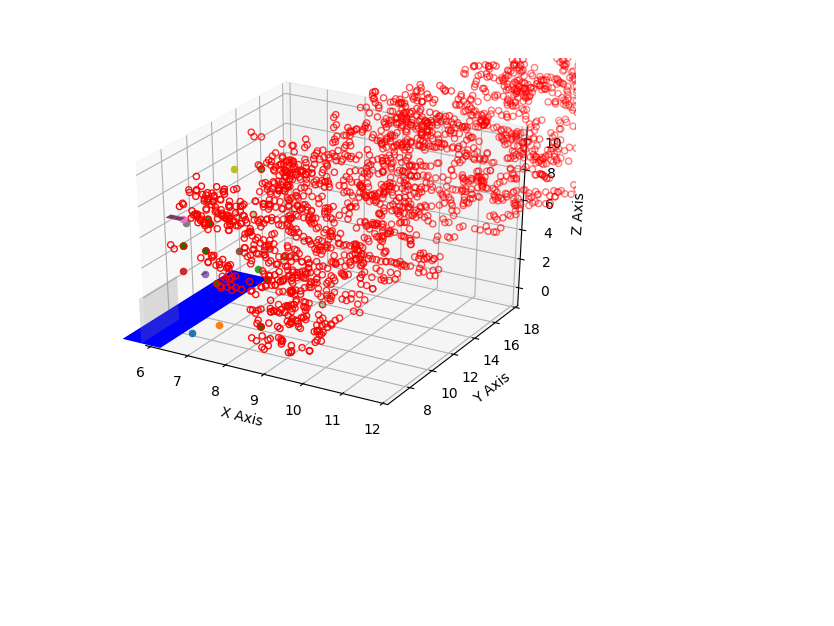

KeyboardInterrupt: 

In [397]:
## plot the vehicle's movement (add other parts as they get finished)    
print("num runs", runs)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.ion() 

fig.show()
fig.canvas.draw()

ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

for run in range(runs):
    time_of_loop = t[run]
    
    if run % 60 == 0:
        ax.clear()
        
        for rows in range(num_row_arms):
            # check if any fruit was picked at this time
            try:        
                # is the if needed when there is a try? => yup, otherwise the points appear at random times
                if fruit_removal[rows][3, index_rem[rows]] < time_of_loop:
                    # add the fruit index to be "removed"
                    index_rem[rows] += 1
            except IndexError:
                print("** Index grew faster than it should have? **")
                print("Index to remove:", index_rem[rows], "in row:", rows, "time:", time_of_loop)
                print("current time value of fruit_removal:", fruit_removal[rows][3, index_rem[rows]-1])
        
        ax.scatter(fruit.sortedFruit[0,:], fruit.sortedFruit[1,:], fruit.sortedFruit[2,:], facecolors='none', edgecolors='r')
        
        for rows in range(num_row_arms):
            ax.scatter(fruit_removal[rows][0,:index_rem[rows]], fruit_removal[rows][1,:index_rem[rows]], fruit_removal[rows][2,:index_rem[rows]], c='g', marker='o')
            
        q_vehicle = [qv0[run], qv1[run]]
        dr.drawRect(q_vehicle, width_v, length_v) # try and draw the vehicle moving along the orchard
        dr.drawFrame(left_edge[run], back_edge[run], front_edge[run], a[0,0].z_edges_f)

        for rows in range(num_row_arms):
            for count in range(num_arms):
                ax.scatter(a[rows,count].qax[run], a[rows,count].qay[run], a[rows,count].qaz[run])
                # need to switch this to a cylinder
#                 dr.drawArmCylinder(center_y, center_z, arm_start, arm_end)
                xc, yc, zc = dr.drawArmCylinder(a[rows,count].qay[run], a[rows,count].qaz[run], a[rows,count].q_f[0], a[rows,count].qax[run])
                ax.plot_surface(xc, yc, zc)


        ax.set_xlim(6, 12)
        ax.set_ylim(q_v[0], end_row+3)
        
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Y Axis')
        ax.set_zlabel('Z Axis')

        fig.canvas.draw()
        time.sleep(0.005)
       
    
    
fig.show()



In [249]:
print("List of the fruits that got passed over by vehicle")
print("ROW 0")
print(row_picture[0].passed_fruit)
print("ROW 1")
print(row_picture[1].passed_fruit)
print("ROW 2")
print(row_picture[2].passed_fruit)

List of the fruits that got passed over by vehicle
ROW 0
[]
ROW 1
[]
ROW 2
[]
